In [1]:
import math
import os
import re
import shutil
import sys
import warnings

import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statistics import median

from constants import bins_axis_names, bin_dimensions_regex, boat_speed_feature, \
                    boxplot_axis_name, feature_regex, identifier_features, \
                    fiber_optics_structure_features, fiber_optics_appendix_features, \
                    other_sensor_features, statistics_features, wind_features

In [2]:
def read_csv(fnames):
    """Read CSV file(s) to a Pandas Dataframe"""
    def detect_and_read(fname):
        with open(fname, 'rb') as f:
            return pd.read_csv(fname, sep=';', encoding=chardet.detect(f.read())['encoding'])
    return pd.concat(map(lambda fname: detect_and_read(fname), fnames), sort=False)

def preprocess_data(df,
                identifier_cols=identifier_features,
                cols_to_preprocess=fiber_optics_structure_features + fiber_optics_appendix_features,
                other_cols=other_sensor_features + wind_features + [boat_speed_feature],
                regex=feature_regex):
    """Preprocess the dataset"""
    preprocessed_df = pd.DataFrame()
    for old_col, new_col in identifier_cols + cols_to_preprocess + other_cols:
        if (old_col, new_col) not in identifier_cols + other_cols:
            preprocessed_df[new_col] = df.filter(regex=(regex.format(old_col))).mean(axis=1)
        else:
            preprocessed_df[new_col] = df[old_col]
    return preprocessed_df

def sort_corr(corr, num_features=20):
    """Sort correlation dictionary"""
    sorted_corr = sorted(corr.items(), key=lambda x: abs(x[1]), reverse=True)[:num_features]
    return sorted(sorted_corr, key=lambda x: x[1], reverse=True)

def compute_sorted_corr(df, target_feature=boat_speed_feature[1], num_features=20):
    """Compute sorted correlated features with the target feature"""
    corr = {}
    for col in df.columns:
        if col != target_feature:
            f_corr = df[target_feature].corr(df[col])
            if not math.isnan(f_corr):
                corr[col] = f_corr
    cols = [target_feature] + [x[0] for x in sort_corr(corr)]
    if len(cols) <= 1:
        return None, None
    return df[cols].corr(), corr

def create_bins(df,
                wind_features=[x[1] for x in wind_features],
                target_feature=boat_speed_feature[1],
                statistics_cols=statistics_features,
                dx=5, dy=2, min_thresh=5,
                exclude=[x[1] for x in identifier_features + wind_features]):
    """Create bins"""
    bins, corr = {}, {}
    for max_x in range(-180, 180, dx):
        for max_y in range(0, math.ceil(df[wind_features[1]].max()), dy):
            binned_df = df.query('{0} >= {2} and {0} < {2}+{4} and {1} >= {3} and {1} < {3}+{5}'.format(wind_features[0], wind_features[1], max_x, max_y, dx, dy))
            bin_size = len(binned_df.index)
            bin_corr, unsorted_corr = compute_sorted_corr(binned_df.drop(exclude, axis=1))
            if bin_size >= min_thresh and bin_corr is not None:
                bin_name = 'bin_x{}to{}_y{}to{}'.format(max_x, max_x+dx, max_y, max_y+dy)
                for col, c_corr in unsorted_corr.items():
                    if col in corr:
                        corr[col].append(c_corr)
                    else:
                        corr[col] = [c_corr]
                bins[bin_name] = {'bin': binned_df, 'size': bin_size, 'corr': bin_corr}
    return bins, dx, dy, max_x, max_y, pd.DataFrame(data=sort_corr({col: median(c_corr) for col, c_corr in corr.items()}), columns=statistics_cols)

def plot_wind_angle_speed(df, x_start, y_start, x_finish, y_finish, dx, dy, markersize, wind_features=[x[1] for x in wind_features], axis_names=bins_axis_names, main=False):
    """Plot the wind angle-speed space"""
    _, ax = plt.subplots()
    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.plot(df[wind_features[0]].tolist(), df[wind_features[1]].tolist(), 'ko', markersize=markersize)
    if main:
        ax.set_xticks(np.arange(x_start, x_finish, dx*6))
        ax.set_xticks(np.arange(x_start, x_finish, dx), minor=True)
        ax.set_yticks(np.arange(y_start, y_finish, dy))
        ax.grid(which='both', lw=.75)
    else:
        ax.set_xlim(x_start, x_finish)
        ax.set_ylim(y_start, y_finish)
        ax.grid(lw=.75)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_boxplot(df, target_feature=boat_speed_feature[1], axis_name=boxplot_axis_name):
    """Plot the boxplot for boat speed"""
    ax = df.boxplot(column=target_feature, showfliers=df[target_feature].median() == df[target_feature].mode().iloc[0], return_type='axes')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_ylabel(axis_name)
    plt.tight_layout()
    plt.show()
    plt.clf()

def plot_corr(corr):
    """Plot the correlations with boat speed"""
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, lw=.75)
    plt.xticks(rotation=30, ha='right', fontsize=5)
    plt.yticks(fontsize=5)
    plt.tight_layout()
    plt.show()
    plt.clf()

In [3]:
# Ignore RunTimeWarning.
warnings.filterwarnings('ignore')

# Ignore PyPlot warning.
plt.rcParams.update({'figure.max_open_warning': 0})

# Version number.
version = 'v2'

# Bins to analyse.
bin_keys = ['bin_x{}to{}_y{}to{}'.format(x_min, x_max, y_min, y_max) for x_min, x_max, y_min, y_max in [(-55, -50, 16, 18),
                                                                                                        (-95, -90, 8, 10),
                                                                                                        (-145, -140, 22, 24),
                                                                                                        (50, 55, 16, 18),
                                                                                                        (140, 145, 22, 24)]]

In [4]:
# Read from CSV file(s).
df = read_csv(map(lambda fname: './data/{}/{}.csv'.format(version, fname), ['data-part-1', 'data-part-2']))

# Preprocess the dataset.
df = preprocess_data(df)

# Create the bins. Default size: 5˚ by 2 knots.
bins, dx, dy, _, max_y, sorted_corr_df = create_bins(df)

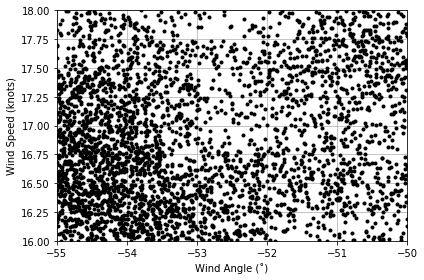

<Figure size 432x288 with 0 Axes>

In [5]:
# Retrieve an example of a bin. (-55 to -50˚, 16 to 18 knots)
bin_name = 'bin_x-55to-50_y16to18'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

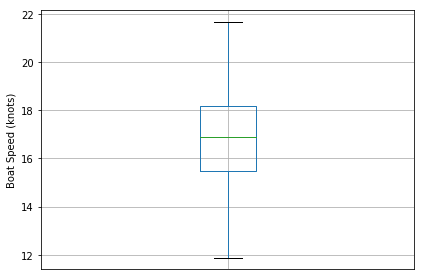

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

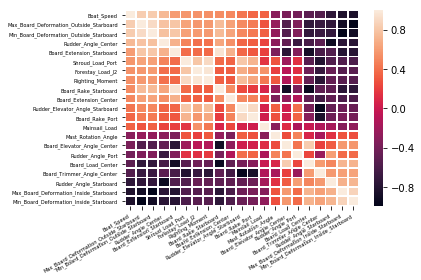

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

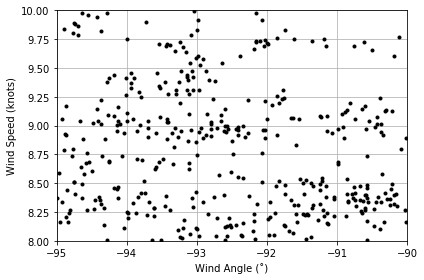

<Figure size 432x288 with 0 Axes>

In [8]:
# Retrieve another example of a bin. (-95 to -90˚, 8 to 10 knots)
bin_name = 'bin_x-95to-90_y8to10'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

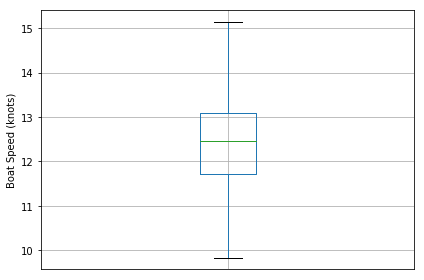

<Figure size 432x288 with 0 Axes>

In [9]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

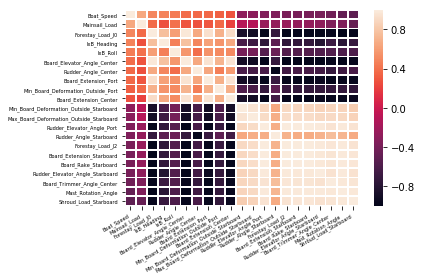

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

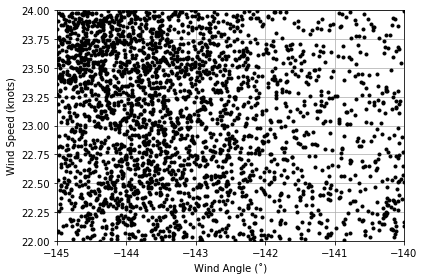

<Figure size 432x288 with 0 Axes>

In [11]:
# Retrieve another example of a bin. (-145 to -140˚, 22 to 24 knots)
bin_name = 'bin_x-145to-140_y22to24'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

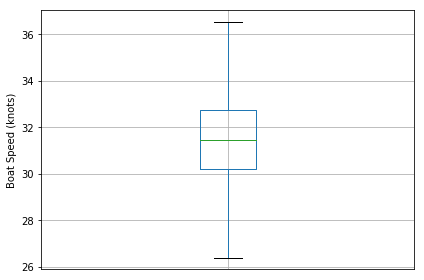

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

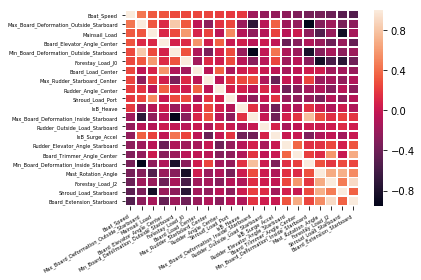

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

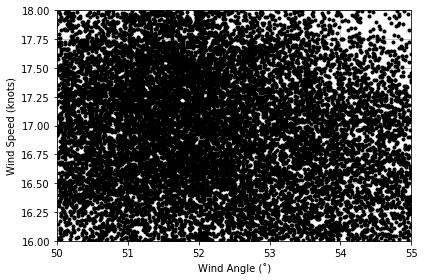

<Figure size 432x288 with 0 Axes>

In [14]:
# Retrieve another example of a bin. (50 to 5˚, 16 to 18 knots)
bin_name = 'bin_x50to55_y16to18'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

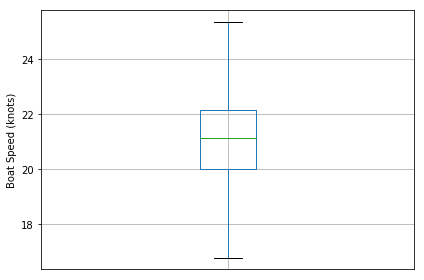

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

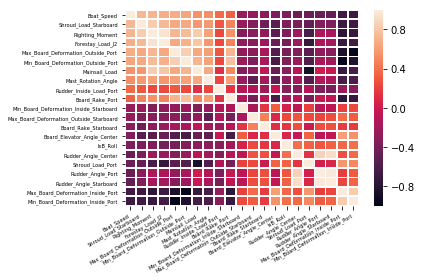

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)

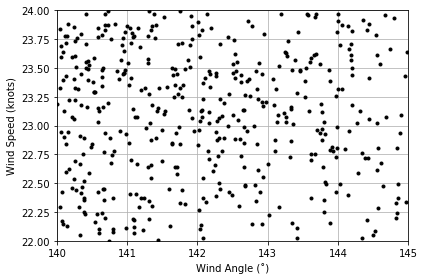

<Figure size 432x288 with 0 Axes>

In [17]:
# Retrieve another example of a bin. (140 to 145˚, 22 to 24 knots)
bin_name = 'bin_x140to145_y22to24'
binned_df, bin_corr = bins[bin_name]['bin'], bins[bin_name]['corr']
x_start, x_finish, y_start, y_finish = [int(s) for s in re.findall(bin_dimensions_regex, bin_name)]
dx, dy = (x_finish-x_start)/4.0, (y_finish-y_start)/4.0

# Plot the bin.
plot_wind_angle_speed(binned_df, x_start, y_start, x_finish, y_finish, dx, dy, 3)

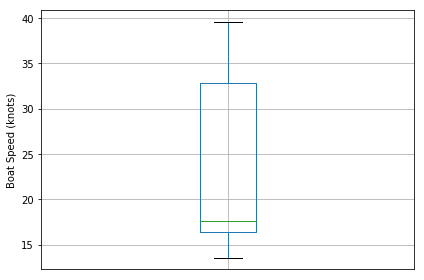

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot the boat speed boxplot.
plot_boxplot(binned_df)

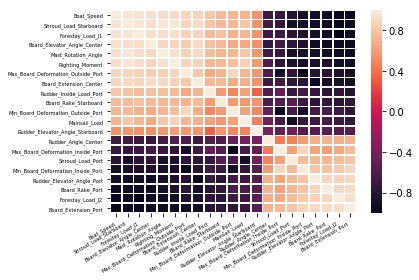

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot the correlation heatmap with boat speed.
plot_corr(bin_corr)